In [1]:
import os, sys
%pylab inline
import pandas as pd
import matplotlib.pyplot as plt
from pprint import pprint
import numpy as np
from tqdm import tqdm

# TODO: fill in the path to downloaded qick repo".
qick_path = ''
sys.path.append(qick_path)

from qick import * 
import time 

# TODO: fill in the path to bitstream files. The bitstream files are in "bitstream files.zip".
bitfile_path = ''

soc = QickSoc(bitfile = bitfile_path)
soccfg = soc
print(soccfg)



Populating the interactive namespace from numpy and matplotlib



QICK configuration:

	Board: ZCU111

	Global clocks (MHz): tProcessor 384.000, RF reference 204.800

	7 signal generator channels:
	0:	axis_signal_gen_v6 - tProc output 1, envelope memory 65536 samples
		DAC tile 0, ch 0, 32-bit DDS, fabric=384.000 MHz, fs=6144.000 MHz
	1:	axis_signal_gen_v6 - tProc output 2, envelope memory 65536 samples
		DAC tile 0, ch 1, 32-bit DDS, fabric=384.000 MHz, fs=6144.000 MHz
	2:	axis_signal_gen_v6 - tProc output 3, envelope memory 65536 samples
		DAC tile 0, ch 2, 32-bit DDS, fabric=384.000 MHz, fs=6144.000 MHz
	3:	axis_signal_gen_v6 - tProc output 4, envelope memory 65536 samples
		DAC tile 1, ch 0, 32-bit DDS, fabric=384.000 MHz, fs=6144.000 MHz
	4:	axis_signal_gen_v6 - tProc output 5, envelope memory 65536 samples
		DAC tile 1, ch 1, 32-bit DDS, fabric=384.000 MHz, fs=6144.000 MHz
	5:	axis_signal_gen_v6 - tProc output 6, envelope memory 65536 samples
		DAC tile 1, ch 2, 32-bit DDS, fabric=384.000 MHz, fs=6144.000 MHz
	6:	axis_signal_gen_v6 - tProc out

In [4]:
soc.readouts

In [ ]:
soc['readouts']

In [10]:
soc['readouts'][1]['trigger_bit']

11

In [2]:

class LoopbackProgram(AveragerProgram):

    def initialize(self):

        cfg=self.cfg   
        n = len(cfg['enabled'])
        
        for i in range(n):
            
            if(not cfg['enabled'][i]): continue  
                
            self.declare_gen(ch=cfg["gen_ch"][i], nqz=1)
      
        

        for i in range(n):
            
            if(not cfg['enabled'][i]): continue
                
            self.declare_readout(ch=cfg["ro_chs"][i], length = self.cfg["readout_length"][i],
                                 freq = self.cfg["pulse_freq"][i], gen_ch = cfg["gen_ch"][i], sel=cfg['sel'][i])


        for i in range(n):
            
            if(not cfg['enabled'][i]): continue

            freq = self.freq2reg(cfg["pulse_freq"][i], gen_ch = cfg["gen_ch"][i], ro_ch = cfg["ro_chs"][i])
            phase = self.deg2reg(0, gen_ch = cfg["gen_ch"][i])
            gain = cfg["pulse_gain"][i]

            self.default_pulse_registers(ch = cfg["gen_ch"][i], freq = freq, phase = phase, gain = gain)

            # style = self.cfg["pulse_style"][i]

            self.set_pulse_registers(ch = cfg["gen_ch"][i], style = "const", length = cfg["length"][i])
        
 
        self.synci(200)  
    

    def body(self):

        cfg=self.cfg
        n = len(cfg['enabled'])
        
        for i in range(n):
            
            if(not cfg['enabled'][i]): continue

            self.trigger(adcs=[cfg['ro_chs'][i]], adc_trig_offset=cfg['trigger_offset'][i])
            self.pulse(ch=cfg["gen_ch"][i])
      
        self.wait_all()
        self.sync_all(self.us2cycles(self.cfg["relax_delay"]))        
      

    

  0%|          | 0/100 [00:00<?, ?it/s]

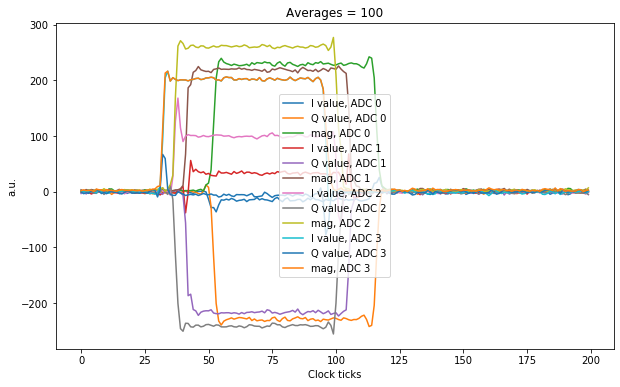

In [37]:




config={
        
        "enabled": [True, True, True, True, False],
        "pulse_freq": [200, 400, 600, 800, 800], # [MHz]
        "gen_ch": [3, 4, 5, 6, 5],
        "pulse_gain": [20000, 6000, 1800, 1800, 28000], 
        "length":[80, 80, 80, 80, 80], # clk ticks.
        "ro_chs": [0, 1, 2, 3, 4], # --Fixed
        "readout_length": [200, 200, 200, 200, 200], 
        "trigger_offset": [80, 80, 80, 80, 250],
        "sel": ['product', 'product', 'product', 'product', 'product'],
        "relax_delay": 1.0, 
        "soft_avgs": 100,
        "reps": 1
        # "pulse_style": ["const", "const", "const", "const"],
       }



prog =LoopbackProgram(soccfg, config)
iq_list = prog.acquire_decimated(soc, load_pulses=True, progress=True, debug=False)



# Plot results.
plt.figure(1, figsize=(10,6))

for ii, iq in enumerate(iq_list):
    
    plt.plot(iq[0], label="I value, ADC %d"%(config['ro_chs'][ii]))
    plt.plot(iq[1], label="Q value, ADC %d"%(config['ro_chs'][ii]))
    plt.plot(np.abs(iq[0] + 1j * iq[1]), label="mag, ADC %d"%(config['ro_chs'][ii]))
    
    
plt.ylabel("a.u.")
plt.xlabel("Clock ticks")
plt.title("Averages = " + str(config["soft_avgs"]))
plt.legend()


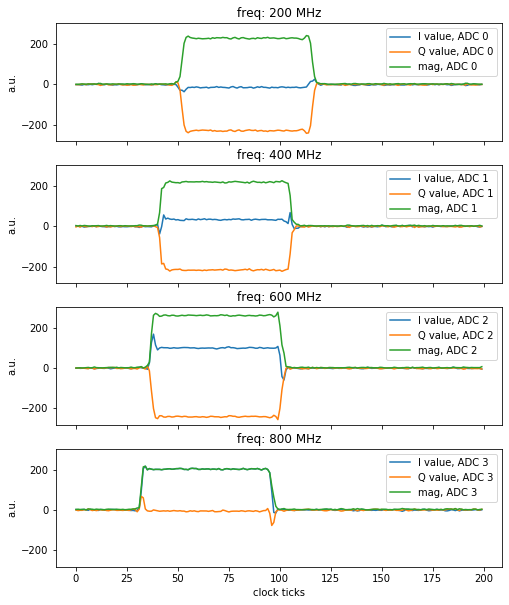

In [41]:


fig, axs = plt.subplots(4, sharex=True, sharey=True, figsize=(8,10))


# for i in range(4):

for i, iq in enumerate(iq_list):    
    axs[i].plot(iq[0], label="I value, ADC %d"%(config['ro_chs'][i]))
    axs[i].plot(iq[1], label="Q value, ADC %d"%(config['ro_chs'][i]))
    axs[i].plot(np.abs(iq[0] + 1j * iq[1]), label="mag, ADC %d"%(config['ro_chs'][i]))
        
    
#     axs[i].plot(a, label='proc '+str(i))
    axs[i].legend()
    axs[i].set_ylabel('a.u.')
    axs[i].set_title(f"freq: {config['pulse_freq'][i]} MHz")

    
    
    
# plt.tight_layout()
# plt.legend()
# plt.xlim([0, 23000])
plt.xlabel('clock ticks')
plt.show()

In [45]:
4096/16

256.0